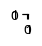

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [3]:
# Load models together
from src.torch_utils import load_model_full
from src.metrics import compute_cosine_distance
from src.utils import get_class_initcode_keys
from src.models import BimodalVAEClassifier, FullTCRVAE, PeptideClassifier
from src.datasets import BimodalTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')
mix_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')


def get_model(folder):
    pt = glob.glob(folder+'/*.pt')[0]
    js = glob.glob(folder+'/*.json')[0]
    model = load_model_full(pt, js, return_json=False, verbose=False)
    return model
    

In [8]:
df = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')
df
# DF has been pre-filled with Xs for missing data.

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type
0,SMWSFNPETNIL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHDN,FVKESK,ASSPLWDRGPLSYGYT,NaN,4,0,peptide_swapped,SPRWYFYYL,VDJdb_80565,35750048,SARS-CoV-2,beta
1,AVFDRKSDAK,TSDQSYG,QGSYDEQN,ALHSGGYQKVT,MNHEY,SMNVEV,ASSPTRPVEQY,HLA-A*11:01,4,0,peptide_swapped,GILGFVFTL,VDJdb_65943,28636592,InfluenzaA,paired
2,KLGGALQAK,TISGTDY,GLTSN,ILTETSYDKVI,SEHNR,FQNEAQ,ASASLGGGLYEQY,HLA-A*03:01,0,0,peptide_swapped,RAKFKQLL,ITRAP_793,37133356,NaN,paired
3,FVDGVPFVV,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHTA,FQGNSA,ASSFGTGWSDEQF,HLA-A*02:01,1,0,peptide_swapped,LPRRSGAAGA,IEDB_23086,28636589,Influenza A virus,beta
4,NLVPMVATV,YGATPY,YFSGDTLV,ALFNFGNDKLT,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,2,0,peptide_swapped,YVLDHLIVV,IEDB_150754,32184241,Human herpesvirus 4 (Epstein Barr virus),alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417088,GLCTLVAML,DRGSQS,IYSNGD,AVNHRDDKII,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,3,0,peptide_swapped,YLQPRTFLL,VDJdb_79199,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,alpha
417089,GLCTLVAML,DSSSTY,IFSNMDM,AESPGSGNTPLVI,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,0,1,IEDB,GLCTLVAML,IEDB_150417,32184241,Human herpesvirus 4 (Epstein Barr virus),alpha
417090,EIYKRWII,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SQVTM,ANQGSEA,SEQAPAGLRPSYNEQ,HLA-B*08:01,1,0,peptide_swapped,GILGFVFTL,IEDB_17378,28250417,Influenza A virus,beta
417091,QLMCQPILLL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHVS,FNYEAQ,ASSLAEGQESSYNSPLH,NaN,3,0,peptide_swapped,YEQYIKWPWYI,IEDB_81268,32793919,SARS-CoV2,beta


In [10]:
df.query('origin!="peptide_swapped" and origin!="10x"')

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type
8,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1,1,VDJdb,TTDPSFLGRY,VDJdb_69875,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,paired
12,KRWIILGLNK,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,MNHNY,SVGAGI,ASSSSPGTSGNQPQH,HLA-B*27:05,2,1,VDJdb,KRWIILGLNK,VDJdb_954,21135165,HIV-1,beta
18,TVATSRTLSYYK,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,LNHDA,SQIVND,ASSTSRGGTEAF,NaN,1,1,IEDB,TVATSRTLSYYK,IEDB_123556,32793919,SARS-CoV1,beta
21,SMWSFNPETNIL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SGHNT,YYREEE,ASSEGGMAYGYT,NaN,1,1,IEDB,SMWSFNPETNIL,IEDB_69947,32793919,SARS-CoV1,beta
34,RLQSLQTYV,TSENNYY,QEAYKQQN,AFDPLYNDMR,XXXXXX,XXXXXXX,XXXXXXXXXXXXXXXXXXXXXXX,HLA-A*02:01,3,1,VDJdb,RLQSLQTYV,VDJdb_4716,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,alpha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417075,FLNGSCGSV,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,WNHNN,SYGVQD,ASSPTDGGADTQY,NaN,2,1,IEDB,FLNGSCGSV,IEDB_107654,32793919,SARS-CoV2,beta
417080,CMTSCCSCLK,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,WSHSY,SAAADI,AIRQDGAEY,NaN,3,1,IEDB,CMTSCCSCLK,IEDB_58798,32793919,SARS coronavirus Tor2 (Severe acute respirator...,beta
417081,FPRPWLHGL,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,SQVTM,ANQGSEA,SVEDSLVNEQF,HLA-B*42:01,1,1,VDJdb,FPRPWLHGL,VDJdb_68648,25911754,HIV-1,beta
417084,VAANIVLTV,TSINN,IRSNERE,AVTGANNLF,LNHDA,SQIVND,ASSIEGPTGELF,HLA-A*02:01,0,1,VDJdb,VAANIVLTV,VDJdb_24025,29429978,HomoSapiens,paired


# Try out mask approach from Copilot

In [46]:
from src.models import SequenceVAE

# Also maybe peptide is not the right modality but we should have a joint A+B modality instead?
from torch import nn
from torch.utils.data import Dataset, DataLoader


class TrimodalVAE(nn.Module):
    def __init__(self, alpha_dim, beta_dim, pep_dim):
        self.vae_alpha = SequenceVAE(alpha_dim)
        self.vae_beta = SequenceVAE(beta_dim)
        self.vae_pep = SequenceVAE(pep_dim)

    
    def forward(self, x_alpha, x_beta, x_pep, mask_alpha, mask_beta, mask_pep):
        mu_alpha, logvar_alpha = self.vae_alpha.encode(x_alpha) if mask_alpha else None, None
        mu_beta, logvar_beta = self.vae_beta.encode(x_beta) if mask_beta else None, None
        mu_pep, logvar_pep = self.vae_pep.encode(x_pep) if mask_pep else None, None
    
        # Get the joint distribution from a product of experts to join the modalities
        mus = [mu for mu in [mu_alpha, mu_beta, mu_pep] if mu is not None]
        logvars = [logvar for logvar in [logvar_alpha, logvar_beta, logvar_pep] if logvar is not None]
        mu_joint, logvar_joint = self.product_of_experts(mus, logvars)
    
        # Decode from the joint latent to capture information shared by the modalities
        z = self.reparameterise(mu_joint, logvar_joint)
        recon_alpha = self.vae_alpha.decode(z) if mask_alpha else None
        recon_beta = self.vae_beta.decode(z) if mask_beta else None
        recon_pep = self.vae_pep.decode(z) if mask_pep else None
    
        return recon_alpha, recon_beta, recon_pep, mu_joint, logvar_joint

class TrimodalDataset(Dataset):
    def __init__(self, df):
        super(TrimodalDataset, self).__init__()
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Should really create the sequence tensors and the mask first, then just 
        alpha = row['sequence_alpha']
        beta = row['sequence_beta']
        peptide = row['sequence_peptide']

        # Compute mask values
        mask_alpha = 1 if pd.notnull(alpha) else 0
        mask_beta = 1 if pd.notnull(beta) else 0
        mask_peptide = 1 if pd.notnull(peptide) else 0

        return mask_alpha, mask_beta, mask_peptide



In [39]:
# Also need to handle how to pad : 
# Whether to pad the concatenated sequence at the end or pad first then concat
df['sequence_alpha'] = df['A1']+df['A2']+df['A3']
df['sequence_beta'] = df['B1']+df['B2']+df['B3']
df['sequence_peptide'] = df['peptide']
df['sequence_alpha'] = df['sequence_alpha'].apply(lambda x: np.nan if all([z=="X" for z in x]) else x)
df['sequence_beta'] = df['sequence_beta'].apply(lambda x: np.nan if all([z=="X" for z in x]) else x)
df['sequence_peptide'] = df['sequence_peptide'].apply(lambda x: np.nan if all([z=="X" for z in x]) else x)

In [151]:
encode_batch(['XXXXXXX'], 12, 'BL50LO', -20)

KeyError: 'X'

In [51]:
from torch.utils.data import SequentialSampler
sample = df.sample(100)
dataset = TrimodalDataset(sample)
loader = DataLoader(dataset, batch_size=32, sampler=SequentialSampler(dataset))
i=0
for batch in loader:
    break

In [53]:
batch[0].shape

torch.Size([32])

In [85]:
def mask_modality(tensor, mask):
    return torch.where(mask.bool(), tensor, torch.zeros_like(tensor))

layers = nn.Sequential(nn.Linear(100, 50), nn.ReLU(), nn.Linear(50, 1))
x = torch.rand(1000, 100)
y = torch.rand(1000, 1)
criterion = nn.MSELoss(reduction='none')
mask = torch.randint(0, 2, (1000,1)).float()
optimizer = torch.optim.SGD(layers.parameters(), lr=1e-4)
z = layers(x)
loss = criterion(y,z)
masked_loss = mask_modality(loss, mask)
masked_loss = masked_loss.mean()

optimizer.zero_grad()
masked_loss.backward()
optimizer.step()

loss.shape, z.shape, y.shape, mask.shape, masked_loss.shape

(torch.Size([1000, 1]),
 torch.Size([1000, 1]),
 torch.Size([1000, 1]),
 torch.Size([1000, 1]),
 torch.Size([]))

In [98]:
torch.randint(0, 2, (1000,)).unsqueeze(1).shape

torch.Size([1000, 1])

In [104]:
def mask_modality(tensor, mask):
    """
    Check that the shapes match, and broadcast if needed in a very crude manner
    Used for example to mask inputs or loss for datapoints with missing modalities
    Assumes (and asserts) that mask has a dimensions <= tensor's dim
    Args:
        tensor: tensor to mask
        mask: mask
    Returns:
        masked_tensor: same tensor but with some elements set to zero
    """
    assert len(mask.shape)<= len(tensor.shape), f'Check mask/tensor dimensions! Mask: {mask.shape} ; Tensor : {tensor.shape}'
    if mask.shape != tensor.shape:
        while len(mask.shape)<len(tensor.shape):
            mask = mask.unsqueeze(1)
    return torch.where(mask.bool(), tensor, torch.zeros_like(tensor))
mask2 = torch.randint(0, 2, (1000,))
mask_modality(loss, mask2)[:10, 0], mask2[:10]

(tensor([0.0872, 0.0000, 0.0000, 0.0605, 0.0000, 0.0000, 0.0067, 0.0000, 0.4428,
         0.0000], grad_fn=<SelectBackward0>),
 tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 0]))

In [88]:
mask2 = torch.randint(0, 2, (1000,)).float()
mask2.shape, len(mask2.shape)

(torch.Size([1000]), 1)

In [95]:
mask = torch.randint(0, 2, (1000,1,1)).float()
mask_modality(x, mask).shape

torch.Size([1000, 1000, 100])

In [111]:
mu = torch.rand(100, 32)
logvar = torch.rand(100, 32)
kld = 1+logvar-mu.pow(2)-logvar.exp()
torch.mean(kld)

tensor(-0.5567)

In [112]:
m1,m2,m3 = torch.rand(100,32),torch.rand(100,32),torch.rand(100,32)
l1,l2,l3 = torch.rand(100,32),torch.rand(100,32),torch.rand(100,32)
def product_of_experts(mus, logvars):
    mu_poe = torch.sum(torch.stack(mus) / torch.exp(torch.stack(logvars)), dim=0) / torch.sum(
        1. / torch.exp(torch.stack(logvars)), dim=0)
    logvar_poe = -torch.log(torch.sum(1. / torch.exp(torch.stack(logvars)), dim=0))
    return mu_poe, logvar_poe
mp, lp = product_of_experts([m1,m2,m3], [l1,l2,l3])
mp.shape, lp.shape

(torch.Size([100, 32]), torch.Size([100, 32]))

In [ ]:
# Currently : dataset is constructed with XXX for missing datapoints : 
# Can feed in the "noisy" data and use mask to ignore specific datapoints for KLD and Reconstruction losses

In [114]:
sample = df.sample(100)

In [156]:
sample['flag_alpha'] = sample.apply(lambda x: not all([z=='X' for z in x['A1']+x['A2']+x['A3']]), axis=1)
sample['flag_beta'] = sample.apply(lambda x: not all([z=='X' for z in x['B1']+x['B2']+x['B3']]), axis=1)
# sample['flag_pep'] = ??
sample[acols+['flag_alpha']].head()


,A1,A2,A3,flag_alpha
182156,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,False
73059,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,False
253205,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,False
357326,VSPFSN,MTFSENT,VGGGTDKLI,True
34119,XXXXXXX,XXXXXXXX,XXXXXXXXXXXXXXXXXXXXXX,False


In [123]:
acols = ['A1', 'A2', 'A3']
sample['alpha_seq'] = sample.apply(lambda x: sum([x[z] for z in acols]), axis=1)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [134]:
x_recon = torch.rand((100, 50))
x_true = torch.rand((100,50))
xmask = torch.randint(0,2, (100,1))

def mask_modality(tensor, mask, fill_value: float = 0.):
    """
    Check that the shapes match, and broadcast if needed in a very crude manner
    Used for example to mask inputs or loss for datapoints with missing modalities
    Assumes (and asserts) that mask has a dimensions <= tensor's dim
    Args:
        tensor: tensor to mask
        mask: Binary mask, should be binary and at least have the same number of elements as tensor (shape[0])
        fill_value (float): value with which to fill the masked version of the tensor. Use 0 when disabling gradients
                            Could be another value to make it easier to mask a reconstructed sequence tensor.
                            For example (ex set to -99) then use tensor[tensor!=-99] to index
    Returns:
        masked_tensor: same tensor but with some elements set to zero
    """
    assert len(mask.shape) <= len(tensor.shape) and mask.shape[0] == tensor.shape[
        0], f'Check mask/tensor dimensions! Mask: {mask.shape} ; Tensor : {tensor.shape}'
    if mask.shape != tensor.shape:
        while len(mask.shape) < len(tensor.shape):
            mask = mask.unsqueeze(1)

    return torch.where(mask.bool(), tensor, torch.full_like(tensor, fill_value))
x_recon_masked = mask_modality(x_recon, xmask, 50)
x_true_masked = mask_modality(x_true, xmask, 50)

In [149]:
x_recon_masked[(x_recon_masked!=50)[:, 0]].shape

torch.Size([45, 50])

In [159]:
alpha_mask = torch.from_numpy(sample['flag_alpha'].values)
alpha_mask.shape

torch.Size([100])

In [174]:
F.mse_loss??

Signature:
F.mse_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
) -> torch.Tensor
Source:   
def mse_loss(
    input: Tensor,
    target: Tensor,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = "mean",
) -> Tensor:
    r"""mse_loss(input, target, size_average=None, reduce=None, reduction='mean') -> Tensor

    Measures the element-wise mean squared error.

    See :class:`~torch.nn.MSELoss` for details.
    """
    if has_torch_function_variadic(input, target):
        return handle_torch_function(
            mse_loss, (input, target), input, target, size_average=size_average, reduce=reduce, reduction=reduction
        )
    if not (target.size() == input.size()):
        warnings.warn(
            "Using a target size ({}) that is different to the input size ({}). "
            "This will likely lead to incorrect results d

In [166]:
torch.from_numpy(sample[acols].sum(axis=1).apply(lambda x: not all([z=="X" for z in x])).values)

tensor([False, False, False,  True, False, False, False, False, False, False,
         True, False,  True, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False, False,  True, False,
        False,  True, False,  True,  True,  True, False,  True, False,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
        False, False,  True, False, False, False,  True, False,  True, False,
         True,  True, False, False, False, False,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False,  True,
         True,  True, False, False, False, False,  True, False, False, False])

In [163]:
alpha_mask

tensor([False, False, False,  True, False, False, False, False, False, False,
         True, False,  True, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False, False,  True, False,
        False,  True, False,  True,  True,  True, False,  True, False,  True,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
        False, False,  True, False, False, False,  True, False,  True, False,
         True,  True, False, False, False, False,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True,  True, False,  True,
         True,  True, False, False, False, False,  True, False, False, False])

In [168]:
x = mask_modality(torch.rand(100,50), alpha_mask, torch.nan)[:10]

In [171]:
x.nanmean(axis=1)

tensor([   nan,    nan,    nan, 0.4890,    nan,    nan,    nan,    nan,    nan,
           nan])

In [183]:
torch.tensor([0.1251252]).round(decimals=3)

tensor([0.1250])

# what the FUCK

In [4]:
from src.models import TrimodalPepTCRVAE
from src.datasets import TrimodalPepTCRDataset
from src.metrics import TrimodalVAELoss
from src.train_eval import trimodal_train_eval_loops, predict_trimodal, train_trimodal_step, eval_trimodal_step

In [5]:
new_df = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')
NEW_PEPMAP = {k:i for i,k in enumerate(sorted(new_df.peptide.unique()))}
pkl_dump(NEW_PEPMAP, '../data/Matrices/240226_nettcr2-2_alpha_beta_paired_pepmap.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/240226_nettcr2-2_alpha_beta_paired_pepmap.pkl saved.


In [196]:
x = torch.rand([100])
x[50]=torch.nan
x.isnan().any()

tensor(True)

In [7]:
new_df.groupby(['input_type']).count()

,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism
input_type,,,,,,,,,,,,,,,
alpha,38427,38427,38427,38427,38427,38427,38427,38427,38427,38427,38427,38427,38427,38427,38279
beta,320052,320052,320052,320052,320052,320052,320052,179566,320052,320052,320052,320052,320052,319698,318485
paired,58614,58614,58614,58614,58614,58614,58614,58614,58614,58614,58614,58614,58614,55674,34898


In [194]:
new_df.sample(frac=0.03).groupby('partition').count()

,peptide,A1,A2,A3,B1,B2,B3,allele,binder,origin,original_peptide,raw_index,reference,source_organism,input_type
partition,,,,,,,,,,,,,,,
0,2538,2538,2538,2538,2538,2538,2538,1644,2538,2538,2538,2538,2523,2396,2538
1,2502,2502,2502,2502,2502,2502,2502,1620,2502,2502,2502,2502,2476,2358,2502
2,2469,2469,2469,2469,2469,2469,2469,1620,2469,2469,2469,2469,2451,2308,2469
3,2479,2479,2479,2479,2479,2479,2479,1635,2479,2479,2479,2479,2459,2330,2479
4,2525,2525,2525,2525,2525,2525,2525,1649,2525,2525,2525,2525,2509,2372,2525


In [8]:
dataset = TrimodalPepTCRDataset(new_df.query('partition!=0'), pad_scale=-20)
loader = dataset.get_dataloader(1024, RandomSampler)

In [9]:
for i, batch in enumerate(loader):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27